# Quick Reproduction Code

The ideia of this notebook is to reproduce some of the results stated in [this article](https://arxiv.org/pdf/1901.10159.pdf). There are a series of shortcuts here:

- I train the classifier on the test dataset of CIFAR-10, which has only 10k images
- I set the hessian milestones only to the beginning and the end of the training

You can run this notebook on "batch" mode, so that you can get results even faster. For a lot of purposes, estimating the spectrum for a small batch can enough. In all the tests I've performed so far, the batch mode gives very close approximations of the global spectrum.

In [14]:
import torch
import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torchvision.transforms as transforms
import torch.optim as optim

import torchessian 
from torchvision.models.resnet import conv3x3, resnet18, ResNet

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

m = 90
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified


In [3]:
def train(
    net, 
    optimizer, 
    scheduler, 
    criterion, 
    L, 
    W, 
    spectrum_type="batch",
    hessian_milestones=[], 
    epochs=15
):
    global testloader
    for epoch in range(epochs):  # loop over the dataset multiple times    

        running_loss = 0.0
        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        scheduler.step()
        
        if epoch in hessian_milestones:
            if spectrum_type == "batch":
                l, w = torchessian.batch_mode.gauss_quadrature(
                                        net, 
                                        criterion, 
                                        (inputs, labels), 
                                        m, 
                                        buffer=m
                )
            elif spectrum_type == "complete":
                l, w = torchessian.complete_mode.gauss_quadrature(
                                        net, 
                                        criterion, 
                                        testloader, 
                                        m, 
                                        buffer=m
                )
            else:
                raise ValueError("Invalid spectrum type.")
                
            L.append(l)
            W.append(w)
            
        if (epoch + 1) % 5 and epoch > 0:
            continue
            
        print('[%d] loss: %.3f' %
              (epoch + 1, running_loss / i))

        running_loss = 0.0


def test(net):
    global testloader
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [4]:
net = resnet18(pretrained=False)
net.fc = torch.nn.Linear(512, 10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)
milestones = [30, 45, 50]
hess_milestones = [0, 59]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, 0.1)
L, W = [], []
train(net, optimizer, scheduler, criterion, L, W, "complete", hess_milestones, 60)
test(net)

[Complete LANCZOS Algorithm running]


100%|██████████| 89/89 [06:14<00:00,  4.27s/it]


[1] loss: 2.394
[5] loss: 1.323
[10] loss: 0.712
[15] loss: 0.197
[20] loss: 0.028
[25] loss: 0.009
[30] loss: 0.006
[35] loss: 0.006
[40] loss: 0.006
[45] loss: 0.006
[50] loss: 0.006
[55] loss: 0.006
[Complete LANCZOS Algorithm running]


100%|██████████| 89/89 [06:17<00:00,  4.27s/it]


[60] loss: 0.006
Accuracy of the network on the 10000 test images: 100 %


In [8]:
class BasicBlockNoBN(torch.nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlockNoBN, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [9]:
net_no_bn = ResNet(BasicBlockNoBN, [2, 2, 2, 2])
net_no_bn.fc = torch.nn.Linear(512, 10)
net_no_bn.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): BasicBlockNoBN(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
      (conv2):

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net_no_bn.parameters(), lr=0.002, momentum=0.9)
milestones = [30, 45, 50]
hess_milestones = [0, 59]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, 0.1)
L_no_bn, W_no_bn = [], []
train(net_no_bn, optimizer, scheduler, criterion, L_no_bn, W_no_bn, "complete", hess_milestones, 60)
test(net_no_bn)

[Complete LANCZOS Algorithm running]


100%|██████████| 89/89 [05:47<00:00,  3.93s/it]


[1] loss: 2.247
[5] loss: 1.408
[10] loss: 1.087
[15] loss: 0.890
[20] loss: 0.716
[25] loss: 0.469
[30] loss: 0.409
[35] loss: 0.175
[40] loss: 0.147
[45] loss: 0.128
[50] loss: 0.120
[55] loss: 0.119
[Complete LANCZOS Algorithm running]


100%|██████████| 89/89 [05:48<00:00,  3.94s/it]


[60] loss: 0.119
Accuracy of the network on the 10000 test images: 98 %


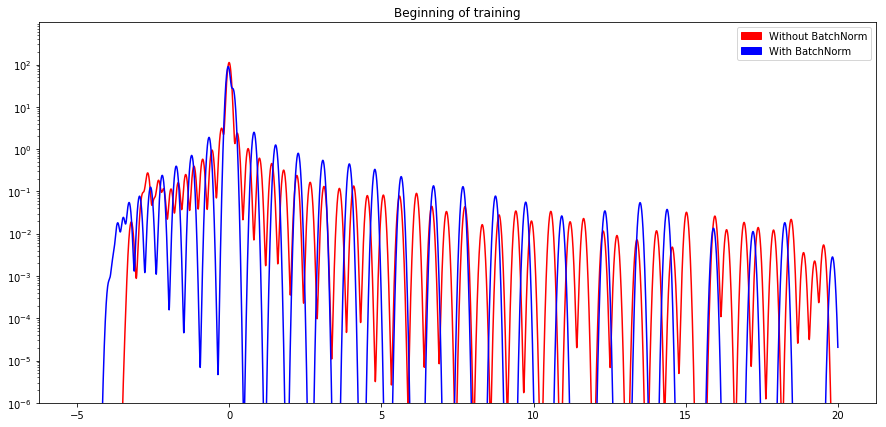

In [20]:
support = torch.linspace(-5, 20, 10000)
density = torchessian.F(support, L_no_bn[0], W_no_bn[0], m)
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(support.numpy(), density.numpy(), color='r')
density = torchessian.F(support, L[0], W[0], m)
ax.plot(support.numpy(), density.numpy(), color='b')
ax.set_yscale('log')
ax.set_yticks([10 ** (i - 7) for i in range(10)])
ax.set_ylim(10 ** -6, 10 ** 3)
red_patch = mpatches.Patch(color='red', label='Without BatchNorm')
blue_patch = mpatches.Patch(color='blue', label='With BatchNorm')
plt.legend(handles=[red_patch, blue_patch])
plt.title("Beginning of training")
plt.show()

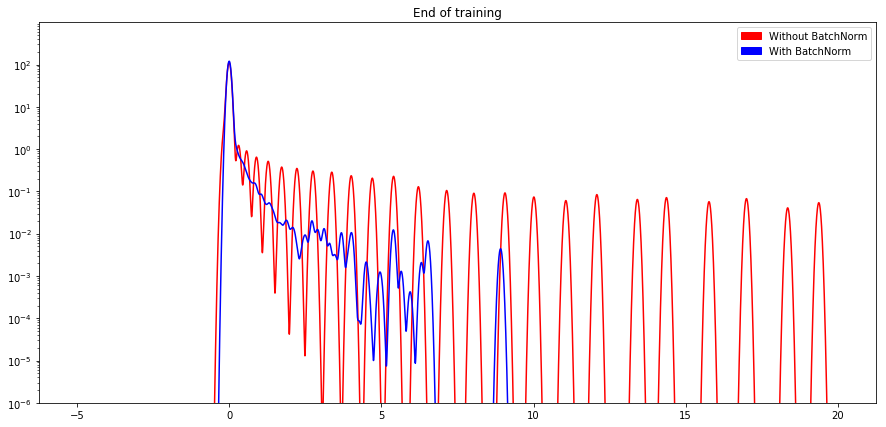

In [21]:
support = torch.linspace(-5, 20, 10000)
density = torchessian.F(support, L_no_bn[-1], W_no_bn[-1], m)
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(support.numpy(), density.numpy(), color='r')
density = torchessian.F(support, L[-1], W[-1], m)
ax.plot(support.numpy(), density.numpy(), color='b')
ax.set_yscale('log')
ax.set_yticks([10 ** (i - 7) for i in range(10)])
ax.set_ylim(10 ** -6, 10 ** 3)
red_patch = mpatches.Patch(color='red', label='Without BatchNorm')
blue_patch = mpatches.Patch(color='blue', label='With BatchNorm')
plt.legend(handles=[red_patch, blue_patch])
plt.title("End of training")
plt.show()